# **FDS - Final Project: Classification of Fake and Real Faces**

## **ResNet-50 Fine-Tuning with Adam Optimizer**

In this notebook we fine-tune ResNet-50 to the 140k fake and real faces dataset. We use hyperparameter tuning to try different combinations of loss function, learning rate and regularization, then compare the results.

#### **Performance Evaluation and Explainability**

* Accuracy, Precision, Recall, F1-Scores
* Confusion Matrix
* Grad-CAM
* ROC curve and AUC score
* Precision-Recall curve


#### Import libraries

In [1]:
pip install grad-cam

In [2]:
!pip install torchcam

In [3]:
import pandas as pd
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import InterpolationMode
from torchvision import transforms, models
from PIL import Image
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torchcam.methods import SmoothGradCAMpp, GradCAM
from torchvision.transforms.functional import to_pil_image
import seaborn as sns
import cv2
from google.colab import drive
from torchvision.models import ResNet50_Weights # Import ResNet50_Weights
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

Mount Google Drive for saving weights later.

In [4]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set random seeds for reproducibility of results.

In [5]:
seed=42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#### Import and read dataset

In [6]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
140k-real-and-fake-faces.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip 140k-real-and-fake-faces.zip -d /content/

Archive:  140k-real-and-fake-faces.zip
replace /content/real_vs_fake/real-vs-fake/test/fake/00276TOPP4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
train_df = pd.read_csv('/content/train.csv', index_col=0)
test_df = pd.read_csv('/content/test.csv', index_col=0)
valid_df = pd.read_csv('/content/valid.csv', index_col=0)
print('Train Dataset Paths and Labels')
display(train_df.head())
print('Test Dataset Paths and Labels')
display(test_df.head())
print('Validation Dataset Paths and Labels')
display(valid_df.head())

Train Dataset Paths and Labels


original_path     id  label label_str  \
0  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  31355      1      real   
1  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  02884      1      real   
2  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  33988      1      real   
3  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  53875      1      real   
4  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  24149      1      real   

                   path  
0  train/real/31355.jpg  
1  train/real/02884.jpg  
2  train/real/33988.jpg  
3  train/real/53875.jpg  
4  train/real/24149.jpg

Test Dataset Paths and Labels


original_path     id  label label_str  \
0  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  18233      1      real   
1  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  54317      1      real   
2  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  40155      1      real   
3  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  12875      1      real   
4  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  52543      1      real   

                  path  
0  test/real/18233.jpg  
1  test/real/54317.jpg  
2  test/real/40155.jpg  
3  test/real/12875.jpg  
4  test/real/52543.jpg

Validation Dataset Paths and Labels


original_path     id  label label_str  \
0  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  20001      1      real   
1  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  11264      1      real   
2  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  19817      1      real   
3  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  46851      1      real   
4  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  10411      1      real   

                   path  
0  valid/real/20001.jpg  
1  valid/real/11264.jpg  
2  valid/real/19817.jpg  
3  valid/real/46851.jpg  
4  valid/real/10411.jpg

Adjust paths in the `path` columns

In [9]:
# Base directory where images are stored
base_img_dir = '/content/real_vs_fake/real-vs-fake/'

# Combine the base path with the relative paths from the 'path' column
train_df['image_path'] = train_df['path'].apply(lambda x: os.path.join(base_img_dir, x))
valid_df['image_path'] = valid_df['path'].apply(lambda x: os.path.join(base_img_dir, x))
test_df['image_path'] = test_df['path'].apply(lambda x: os.path.join(base_img_dir, x))

#### Visualize some images

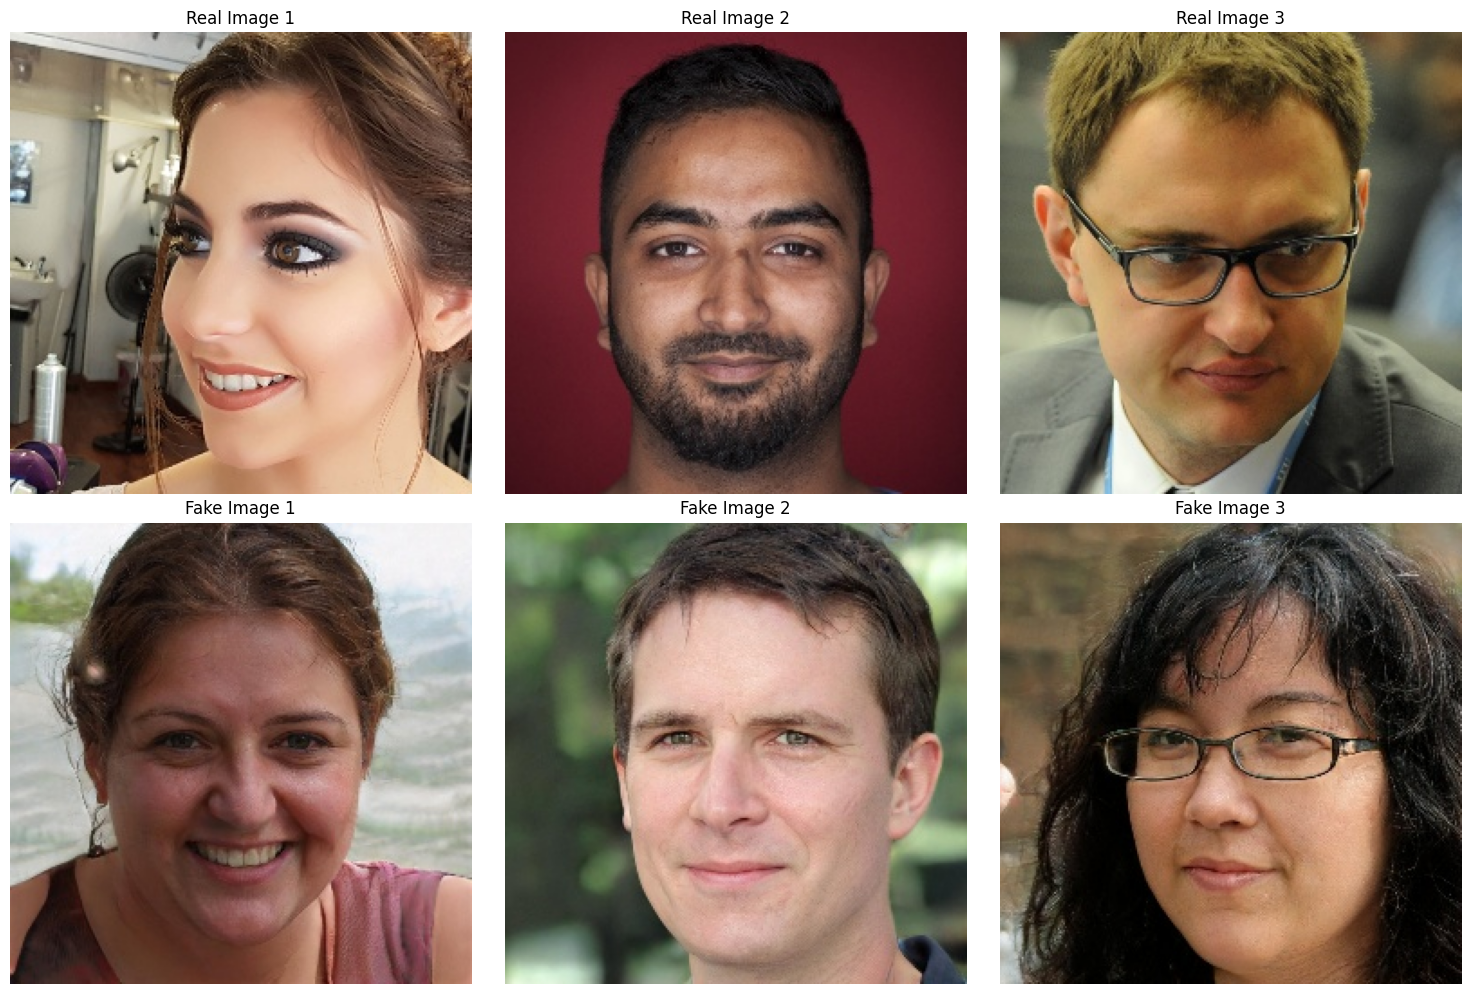

In [10]:
# Pick 3 real and 3 fake images to show
real_imgs_to_show = random.sample(list(train_df[train_df.label == 1].image_path), 3)
fake_imgs_to_show = random.sample(list(train_df[train_df.label == 0].image_path), 3)

# Open images using PIL
real_images = [Image.open(path) for path in real_imgs_to_show]
fake_images = [Image.open(path) for path in fake_imgs_to_show]

# Display images side by side using Matplotlib
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Add real images in the first row
for ax, img, title in zip(axes[0], real_images, ["Real Image 1", "Real Image 2", "Real Image 3"]):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

# Add fake images in the second row
for ax, img, title in zip(axes[1], fake_images, ["Fake Image 1", "Fake Image 2", "Fake Image 3"]):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

#### Create FaceDataset class
We create a FaceDataset class that can be passed to a DataLoader, which will take care of batching and shuffling.

In [11]:
class FaceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        '''
        Args:
            dataframe (pd.DataFrame): DataFrame containing image paths and labels
            transform (callable, optional): Optional transform to be applied on a sample
        '''
        self.dataframe = dataframe  # Store the dataframe
        self.transform = transform  # Store the transform (if present)

    def __len__(self):
        return len(self.dataframe)  # Return the length of the dataframe

    def __getitem__(self, idx):
        # Get the image path and label from the dataframe
        img_path = self.dataframe.iloc[idx].image_path
        label = int(self.dataframe.iloc[idx].label)  # Label is 0 or 1 (fake or real)

        # Open the image using PIL
        image = Image.open(img_path)

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label  # Return image and label

## Fine-Tuning ResNet-50 to the Dataset

#### Load ResNet50

We will use the pre-trained CNN ResNet-50 and fine-tune it to the 140k-real-and-fake-faces dataset, then compare its accuracy to that of other models. We downloaded the ResNet-50 weights at https://download.pytorch.org/models/resnet50-11ad3fa6.pth and uploaded them to the Kaggle environment as Input. ResNet-50 expects images that are pre-processed with specific transformations specified at https://pytorch.org/vision/0.18/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50 (reference can also be found here: https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198). There are two transformation recipes for pre-processing the data to pass into the ResNet-50 CNN; we choose the more recent recipe.

In [12]:
from torchvision.models import ResNet50_Weights # Import ResNet50_Weights

# Load pre-trained ResNet50
resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Modify the final fully connected layer for binary classification
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 2)  # Output logits for 2 classes

# Define transformations to preprocess the images
resnet50_transform = transforms.Compose([
    transforms.Resize(232, interpolation=InterpolationMode.BILINEAR),  # Resize the image to size [232]
    transforms.CenterCrop(224),  # Crop the image to size [224]
    transforms.ToTensor(),  # Convert the image to tensor and scale values to [0.0, 1.0]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using resnet50 mean and std parameters
])

In [13]:
# Create Dataset instances for train, validation, and test sets
train_dataset = FaceDataset(dataframe=train_df, transform=resnet50_transform)
valid_dataset = FaceDataset(dataframe=valid_df, transform=resnet50_transform)
test_dataset = FaceDataset(dataframe=test_df, transform=resnet50_transform)

# Create DataLoader instances for efficient batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check the first batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)
print('Batch Shape:')
print(images.shape)
print('\nNumber of Labels:')
print(labels.shape)

Batch Shape:
torch.Size([64, 3, 224, 224])

Number of Labels:
torch.Size([64])


#### Cross Entropy Loss + Adam Optimizer + learning rate 0.001

In [14]:
# Set device to cuda if it is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Move model to the right device
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = optim.Adam(resnet50.parameters(), lr=0.001) # Adam optimizer

In the following code, we fine-tune the ResNet-50 model to the Face Dataset:

In [16]:
# Initialize lists for accuracies, losses, Grad-CAM images, probabilities of predicting class 1
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
true_labels = []
pred_labels = []
cam_images = []
probs = []

num_epochs = 5

# Iterate over the epochs
for epoch in range(num_epochs):
    # Training Phase
    resnet50.train()  # Set the model to training mode
    train_running_loss = 0.0
    correct, total = 0, 0
    prob = []

    # Iterate over the batches
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available

        # Set parameter gradients to zero
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet50(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Optimization
        optimizer.step()

        # Increase training loss
        train_running_loss += loss.item()

        # Calculate accuracy
        predicted = torch.max(outputs, 1)[1]  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss for the training epoch
    avg_train_loss = train_running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Calculate training accuracy
    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}: Training Loss = {avg_train_loss:.4f}, Training Accuracy = {train_accuracy:.4f}")

    # Validation Phase
    resnet50.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    val_correct, val_total = 0, 0

    for val_inputs, val_labels in tqdm(valid_loader):
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        # Forward pass
        val_outputs = resnet50(val_inputs)

        with torch.no_grad():  # Ensure no gradients for most of the validation loop

            # Compute loss
            val_loss = criterion(val_outputs, val_labels)

            # Increase validation loss
            val_running_loss += val_loss.item()

            # Calculate accuracy
            val_predicted = torch.max(val_outputs, 1)[1]  # Get predicted class
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

            # Memorize true and predicted labels for explainability
            true_labels.extend(val_labels.cpu().numpy())
            pred_labels.extend(val_predicted.cpu().numpy())

        # Calculate probabilities for prediction = class 1 (real) using softmax
        prob.extend(torch.softmax(val_outputs, dim=1)[:, 1].cpu().detach().numpy())

    # Calculate average loss for the validation epoch
    avg_val_loss = val_running_loss / len(valid_loader)
    val_losses.append(avg_val_loss)

    # Calculate validation accuracy
    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    # Add the prob list to probs
    probs.append(prob)

    print(f"Validation Loss = {avg_val_loss:.4f}, Validation Accuracy = {val_accuracy:.4f}")

print('Finished Training')

100%|██████████| 1563/1563 [07:05<00:00,  3.67it/s]


Epoch 1: Training Loss = 0.0793, Training Accuracy = 0.9691


100%|██████████| 313/313 [01:07<00:00,  4.65it/s]


Validation Loss = 0.3485, Validation Accuracy = 0.8949


100%|██████████| 1563/1563 [06:53<00:00,  3.78it/s]


Epoch 2: Training Loss = 0.0347, Training Accuracy = 0.9869


100%|██████████| 313/313 [01:05<00:00,  4.76it/s]


Validation Loss = 0.0450, Validation Accuracy = 0.9848


100%|██████████| 1563/1563 [06:55<00:00,  3.77it/s]


Epoch 3: Training Loss = 0.0257, Training Accuracy = 0.9907


100%|██████████| 313/313 [01:06<00:00,  4.73it/s]


Validation Loss = 0.0383, Validation Accuracy = 0.9850


100%|██████████| 1563/1563 [07:01<00:00,  3.71it/s]


Epoch 4: Training Loss = 0.0213, Training Accuracy = 0.9923


100%|██████████| 313/313 [01:06<00:00,  4.73it/s]


Validation Loss = 0.0235, Validation Accuracy = 0.9912


100%|██████████| 1563/1563 [06:54<00:00,  3.77it/s]


Epoch 5: Training Loss = 0.0180, Training Accuracy = 0.9933


100%|██████████| 313/313 [01:05<00:00,  4.75it/s]

Validation Loss = 0.0253, Validation Accuracy = 0.9917
Finished Training


This notebook was run on Colab, so we save the model's trained weights in a pth file on Google Drive:

In [17]:
CE_Adam_001_checkpoint = {
    'epoch': epoch,
    'model_state_dict': resnet50.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'train_losses': train_losses,
    'val_losses': val_losses,
}
CE_Adam_001_checkpoint_path = '/content/drive/MyDrive/CE_Adam_001_checkpoint.pth'
torch.save(CE_Adam_001_checkpoint, CE_Adam_001_checkpoint_path)

We can use Grad-CAM to interpret the results.

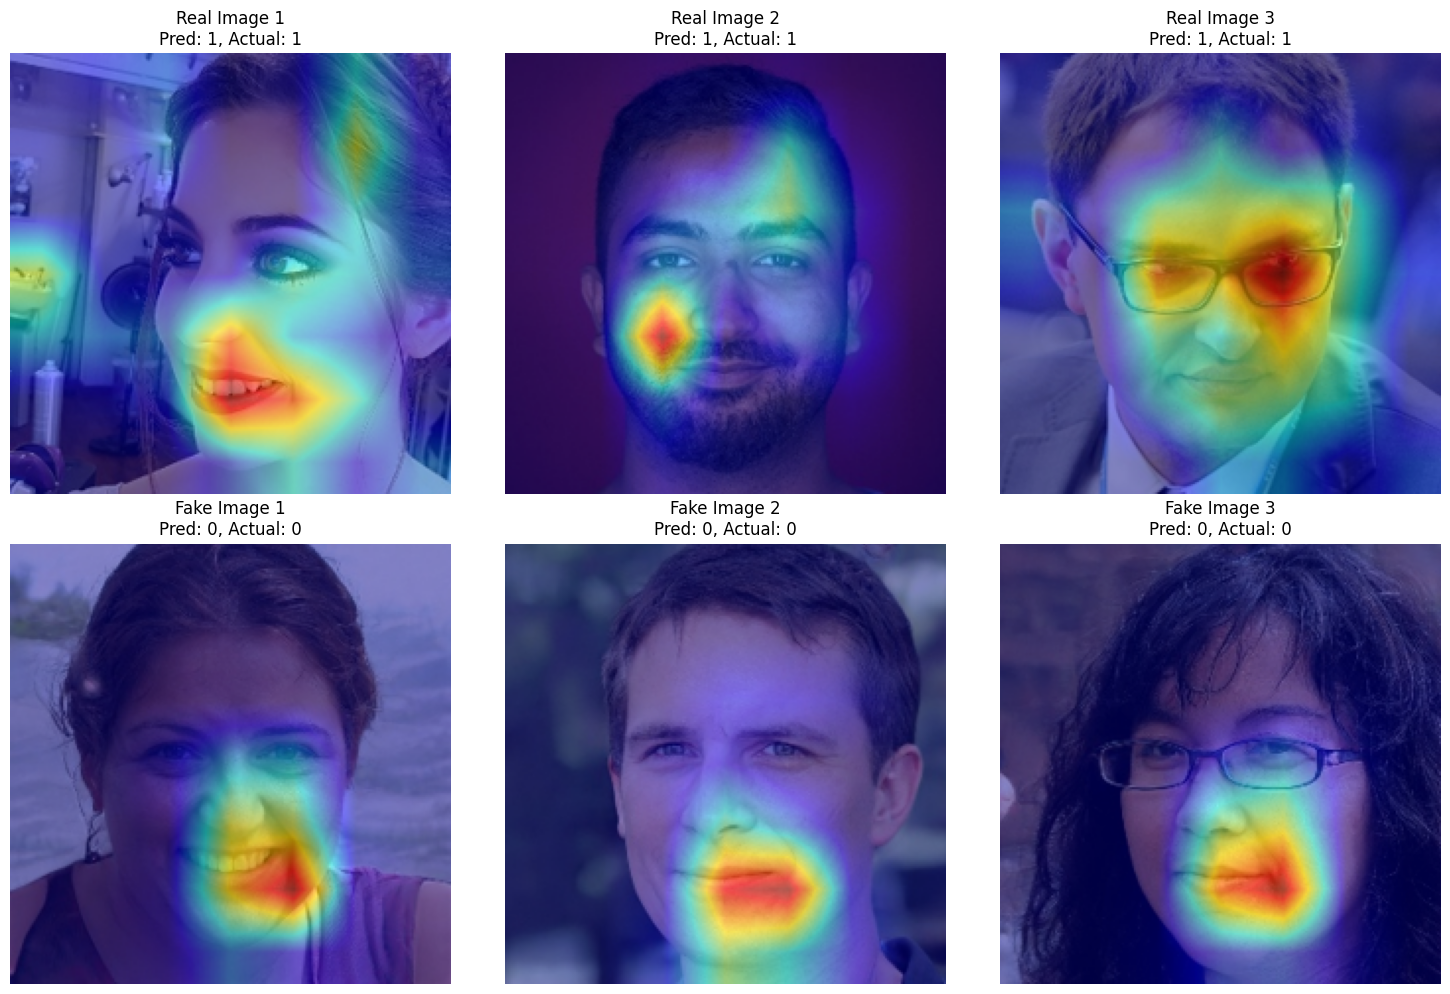

In [18]:
# Set the model to evaluation mode
resnet50.eval()

# Define the target layer for Grad-CAM
target_layer = resnet50.layer4[-1]

# Initialize Grad-CAM
cam = GradCAM(model=resnet50, target_layers=[target_layer])

# Function to process an image and generate Grad-CAM heatmap
def generate_gradcam_overlay(img_path, target_class):
    # Load and preprocess the image
    image = Image.open(img_path).convert('RGB')
    img_tensor = resnet50_transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Convert the image to a NumPy array for visualization
    img_for_visualization = np.array(image.resize((224, 224))) / 255.0  # Scale to [0, 1]

    # Generate Grad-CAM heatmap
    grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(target_class)])
    heatmap = grayscale_cam[0, :]  # Extract the heatmap

    # Overlay heatmap on the image
    superimposed_img = show_cam_on_image(img_for_visualization, heatmap, use_rgb=True)

    # Get model prediction
    with torch.no_grad():
        output = resnet50(img_tensor)
        pred_class = output.argmax(dim=1).item()

    return superimposed_img, pred_class

# Create a 2x3 plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# First row: Real images
for i, img_path in enumerate(real_imgs_to_show):
    target_class = 1  # Actual label for real images
    superimposed_img, pred_class = generate_gradcam_overlay(img_path, target_class)
    axes[0, i].imshow(superimposed_img)
    axes[0, i].set_title(f"Real Image {i+1}\nPred: {pred_class}, Actual: {target_class}")
    axes[0, i].axis("off")

# Second row: Fake images
for i, img_path in enumerate(fake_imgs_to_show):
    target_class = 0  # Actual label for fake images
    superimposed_img, pred_class = generate_gradcam_overlay(img_path, target_class)
    axes[1, i].imshow(superimposed_img)
    axes[1, i].set_title(f"Fake Image {i+1}\nPred: {pred_class}, Actual: {target_class}")
    axes[1, i].axis("off")

# Adjust layout and display
plt.tight_layout()
plt.show()

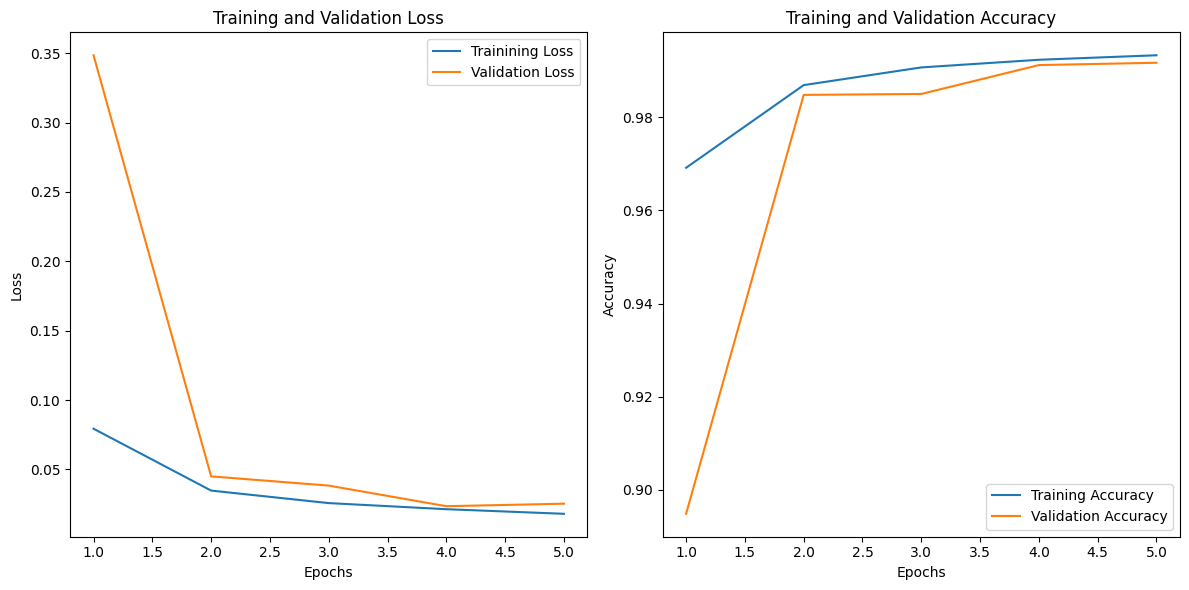

In [19]:
# Plotting loss curves

plt.figure(figsize=(12, 6))

# Plot the training and validation loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Trainining Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Save results in a DataFrame
resnet50_results = pd.DataFrame(
    zip(range(1, num_epochs + 1), train_losses, train_accuracies, val_losses, val_accuracies),
    columns=['Epoch', 'Training Losses', 'Training Accuracies', 'Validation Losses', 'Validation Accuracies']
)

# Display accuracy results
display(resnet50_results)

Epoch  Training Losses  Training Accuracies  Validation Losses  \
0      1         0.079316              0.96915           0.348550   
1      2         0.034709              0.98690           0.044953   
2      3         0.025693              0.99070           0.038306   
3      4         0.021298              0.99234           0.023457   
4      5         0.017982              0.99331           0.025264   

   Validation Accuracies  
0                0.89485  
1                0.98480  
2                0.98500  
3                0.99120  
4                0.99170

In [21]:
report = classification_report(true_labels, pred_labels, target_names=['Fake', 'Real'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

        Fake       0.99      0.94      0.97     50000
        Real       0.95      0.99      0.97     50000

    accuracy                           0.97    100000
   macro avg       0.97      0.97      0.97    100000
weighted avg       0.97      0.97      0.97    100000



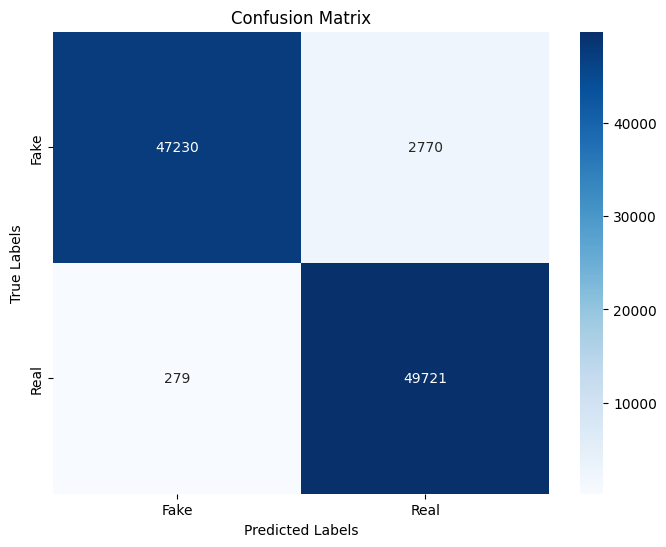

In [22]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=True, xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

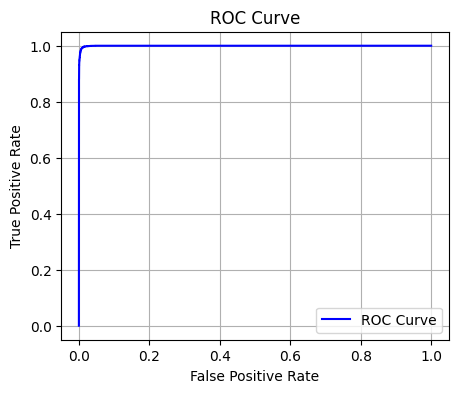

AUC: 0.9996


In [27]:
# Print ROC curve and AUC score
fpr, tpr, _ = roc_curve(true_labels[-20000:], probs[-1])  # probs are lists of predicted probabilities for class 1

# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
#plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# AUC score
auc = roc_auc_score(true_labels[-20000:], probs[-1])
print(f"AUC: {auc:.4f}")

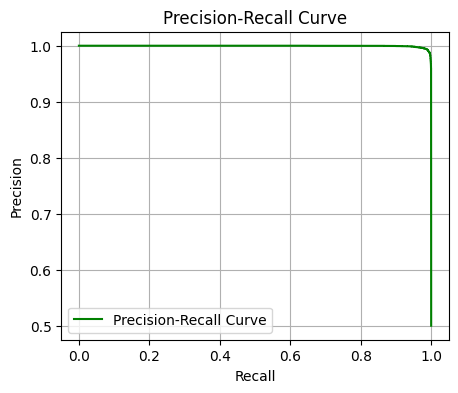

In [29]:
# Plot Precision Recall Curve
precision, recall, _ = precision_recall_curve(true_labels[-20000:], probs[-1])

plt.figure(figsize=(5, 4))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

Now we evaluate the model on the test part of the dataset:

100%|██████████| 313/313 [01:09<00:00,  4.50it/s]


Accuracy: 0.9926
Precision: 0.9891
Recall: 0.9961
F1 Score: 0.9926
ROC AUC: 0.9925


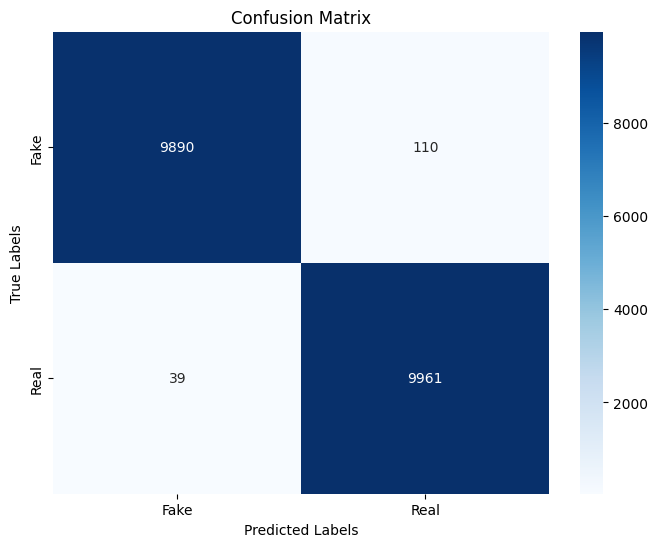

In [30]:
# Get predictions on the test set
resnet50.eval()
with torch.no_grad():
    test_predictions = []
    test_true_labels = []
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(test_true_labels, test_predictions)
precision = precision_score(test_true_labels, test_predictions, average='binary')
recall = recall_score(test_true_labels, test_predictions, average='binary')
f1 = f1_score(test_true_labels, test_predictions, average='binary')
roc_auc = roc_auc_score(test_true_labels, test_predictions)

# Confusion Matrix
test_conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=True, xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()